In [1]:
from io import BytesIO
import requests

import numpy as np
import matplotlib.pyplot as plt
import ee
import rasterio
from scipy import ndimage as ndi
from skimage.transform import resize
from skimage.segmentation import watershed

In [2]:
# TEMP. GLOBAL ATTRIBUTES

x_min = 597500
y_min = 657450
x_max = 597600
y_max = 657550

resolution = 0.5 # usable only for geoportal images
size = (abs(int((x_min - x_max)/resolution)), abs(int((y_min - y_max)/resolution))) # for comparing sources

col_source="COPERNICUS/S2"
col_time_start = "2020-01-01" 
col_time_end = "2020-06-01"
max_clouds = 3

In [3]:
# GEE SETUP
# ee.Authenticate(quiet=True) # should be run once (?)
ee.Initialize()

In [4]:
# GEE IMAGE
def get_gee_rgb_image(
    aoi,
    col_source="COPERNICUS/S2", 
    col_time_start="2020-01-01", 
    col_time_end="2020-06-01", 
    max_clouds=10,
    size=None
):
    x_min, y_min, x_max, y_max = aoi
    
    projection = ee.Projection("EPSG:2180")
    polygon_2180 = ee.Geometry.Rectangle([x_min, y_min, x_max, y_max], projection, True, False);

    image =ee.ImageCollection(
        col_source
    ).filterDate(
        col_time_start, col_time_end
    ).filterBounds(
        polygon_2180
    ).filterMetadata(
        "CLOUDY_PIXEL_PERCENTAGE", "less_than", max_clouds
    ).first()
    
    # Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
    band_arrs = image.sampleRectangle(region=polygon_2180, defaultValue=0.0)

    # Get individual band arrays.
    band_arr_b4 = band_arrs.get('B4')
    band_arr_b3 = band_arrs.get('B3')
    band_arr_b2 = band_arrs.get('B2')

    # Transfer the arrays from server to client and cast as np array.
    np_arr_b4 = np.array(band_arr_b4.getInfo())
    np_arr_b3 = np.array(band_arr_b3.getInfo())
    np_arr_b2 = np.array(band_arr_b2.getInfo())

    # Stack the individual bands to make a 3-D array.
    rgb_img = np.dstack((np_arr_b4, np_arr_b3, np_arr_b2))
    print(rgb_img.shape)

    # Scale the data to [0, 255] to show as an RGB image.
    rgb_img_test = (255*((rgb_img)/3500)).astype('uint8')
    
    if size is not None:
        rgb_img_test = resize(rgb_img_test, size)
    
    return rgb_img_test

In [5]:
ee_img = get_gee_rgb_image((x_min, y_min, x_max, y_max), col_source, col_time_start, col_time_end, max_clouds, size)
# plt.imshow(ee_img)

(11, 11, 3)


In [6]:
# GEOPORTAL ORTO
def get_orto_image(aoi, resolution):
    x_min, y_min, x_max, y_max = aoi
    
    orto_wms_url = "mapy.geoportal.gov.pl/wss/service/img/guest/ORTO/MapServer/WMSServer"

    layer = 'Raster'
    resolution = resolution
    size = (abs(int((x_min - x_max)/resolution)), abs(int((y_min - y_max)/resolution)))
    print(size)

    params = {
        'request': 'GetMap',
        'service': 'WMS',
        'version': '1.1.1',
        'layers': layer,
        'styles': '',
        'width': size[0],
        'height': size[1],
        'srs': 'EPSG:2180',
        'bbox': ','.join((str(x) for x in (x_min, y_min, x_max, y_max))),
        'format': 'image/png',
        'transparent': 'TRUE'
    }

    parsed_url = orto_wms_url + "?" + "&".join([f"{k.upper()}={v}" for k,v in params.items()])

    response = requests.get("http://" + parsed_url)
    print(response.ok)

    img = BytesIO(response.content)

    with rasterio.MemoryFile(img) as memfile:
         with memfile.open() as dataset:
                data_array = dataset.read()
                data_array = np.moveaxis(data_array, 0, 2)
    
    return data_array

In [7]:
img_orto = get_orto_image((x_min, y_min, x_max, y_max), resolution)
# plt.imshow(img_orto)

(200, 200)
True


/home/l_sawaniewski/anaconda3/envs/balticsatapp/lib/python3.7/site-packages/rasterio/io.py:130: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  return DatasetReader(mempath, driver=driver, sharing=sharing, **kwargs)


In [8]:
# GEOPORTAL BUILDINGS
def get_building_mask(aoi, resolution):
    x_min, y_min, x_max, y_max = aoi
    build_wms_url = "integracja.gugik.gov.pl/cgi-bin/KrajowaIntegracjaEwidencjiGruntow"

    layer = 'budynki'
    resolution = resolution
    size = (abs(int((x_min - x_max)/resolution)), abs(int((y_min - y_max)/resolution)))
    print(size)

    params = {
        'request': 'GetMap',
        'service': 'WMS',
        'version': '1.1.1',
        'layers': layer,
        'styles': '',
        'width': size[0],
        'height': size[1],
        'srs': 'EPSG:2180',
        'bbox': ','.join((str(x) for x in (x_min, y_min, x_max, y_max))),
        'format': 'image/png',
        'transparent': 'TRUE'
    }

    parsed_url = build_wms_url + "?" + "&".join([f"{k.upper()}={v}" for k,v in params.items()])

    response = requests.get("http://" + parsed_url)
    print(response.ok)

    img = BytesIO(response.content)

    with rasterio.MemoryFile(img) as memfile:
         with memfile.open() as dataset:
                data_array = dataset.read()
                data_array = data_array[0] > 0
    
    # filling contours
    data_array = ndi.binary_fill_holes(data_array)
    # filling oupen contours with watershed
    water_mask = watershed(data_array)
    water_mask = water_mask != np.bincount(water_mask.flatten()).argmax()
    data_array = water_mask + data_array
    
    return data_array

In [9]:
build_mask = get_building_mask((x_min, y_min, x_max, y_max), resolution)
# plt.imshow(build_mask)

(200, 200)
True


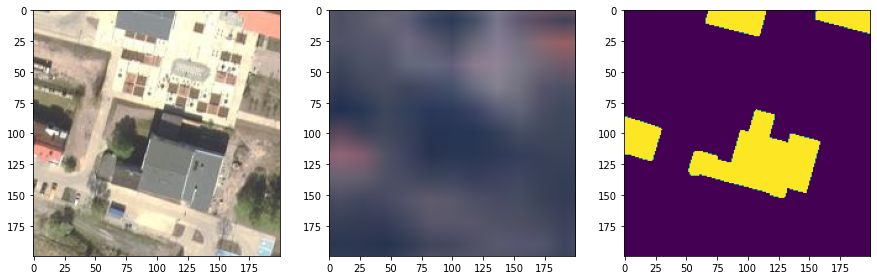

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15,15))

axs[0].imshow(img_orto)
axs[1].imshow(ee_img)
axs[2].imshow(build_mask)